In [2]:
!pip install opencv-python

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import numpy as np
import cv2
import seaborn as sns

import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
from glob import glob

from sklearn import preprocessing, manifold, decomposition, cluster, metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.cluster import KMeans
import re
import time
import pickle

import sys
import os
import warnings
warnings.filterwarnings("ignore")

## Configuration du chemin d'accès aux données

In [4]:
path_data = './data/'
path_images = path_data + 'Images/'

## Vérification des fichiers disponibles dans le répertoire de données

In [5]:
os.listdir(path_data)

['API',
 'dataset_test',
 'dataset_train',
 'data_clean.csv',
 'data_test.csv',
 'data_train.csv',
 'features_saved',
 'Images',
 'Images_categories',
 'Model']

## Chargement des données

Enfin, chargeons le fichier de données des clients pour commencer notre exploration.

In [6]:
# Chargement des données
data = pd.read_csv(path_data + 'data_clean.csv')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   uniq_id                1050 non-null   object
 1   product_name           1050 non-null   object
 2   image                  1050 non-null   object
 3   description            1050 non-null   object
 4   product_category_tree  1050 non-null   object
 5   main_category          1050 non-null   object
 6   label_main_category    1050 non-null   int64 
 7   sub_category           1050 non-null   object
 8   description_clean      1050 non-null   object
dtypes: int64(1), object(8)
memory usage: 74.0+ KB


# Préparation du dataset 

In [8]:
path_train = path_data + "dataset_train/"
path_test = path_data + "dataset_test/"

In [9]:
# Fonction pour extraire la catégorie à partir du chemin de l'image
def photo_class(photo):
    # Extrait le nom de la catégorie à partir du chemin de l'image
    category = os.path.basename(os.path.dirname(photo))
    return category

# Récupération des chemins des images pour les ensembles d'entraînement et de test
data_path = glob(path_train + '*/*.jp*')
data_test_path = glob(path_test + '*/*.jp*')

# Fonction pour créer un DataFrame à partir des chemins des images
def data_fct(path):
    list_photos = [file for file in path]
    print(f"Nombre de photos: {len(list_photos)}")
    data = pd.DataFrame()
    data["image_path"] = list_photos
    data["label_name"] = data["image_path"].apply(lambda x: photo_class(x))
    return data

# Création des DataFrames pour les ensembles d'entraînement et de test
data = data_fct(data_path)
data_test = data_fct(data_test_path)

# Encodage des labels
le = preprocessing.LabelEncoder()
le.fit(data["label_name"])
data["label"] = le.transform(data["label_name"])
data_test["label"] = le.transform(data_test["label_name"])

# Affichage des DataFrames pour vérifier les résultats
print(data.head(1))
print(data_test.head(1))

Nombre de photos: 840
Nombre de photos: 210
                                          image_path label_name  label
0  ./data/dataset_train\Baby Care\057836ecde71565...  Baby Care      0
                                          image_path label_name  label
0  ./data/dataset_test\Baby Care\0bff0eda7a6677dc...  Baby Care      0


In [10]:
data.groupby("label").count()

,image_path,label_name
label,,
0,123,123
1,129,129
2,112,112
3,120,120
4,115,115
5,124,124
6,117,117


In [11]:
data_test.groupby("label").count()

,image_path,label_name
label,,
0,27,27
1,21,21
2,38,38
3,30,30
4,35,35
5,26,26
6,33,33


Baby Care


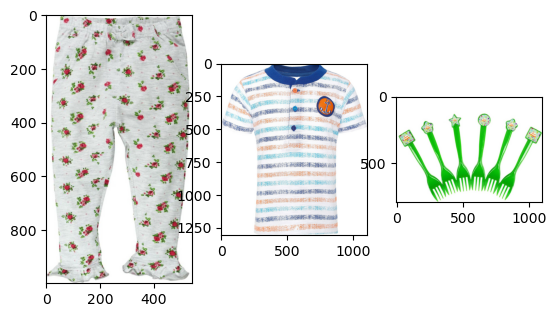

Beauty and Personal Care


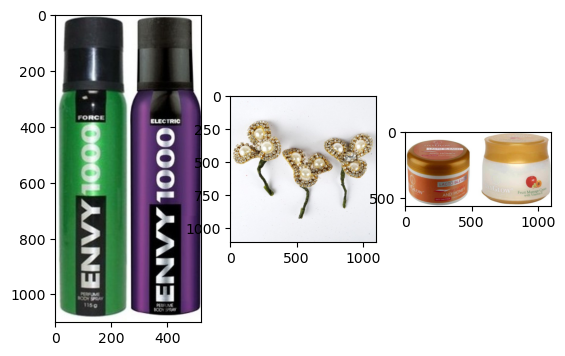

Computers


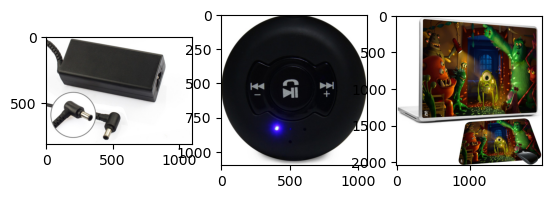

Home Decor & Festive Needs


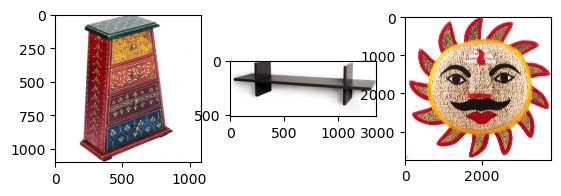

Home Furnishing


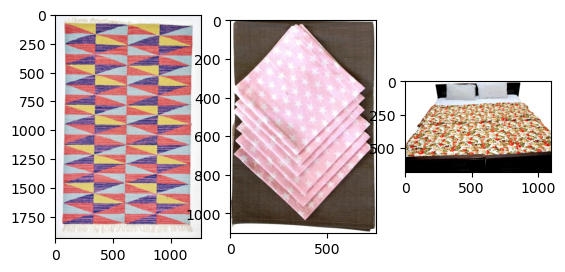

Kitchen & Dining


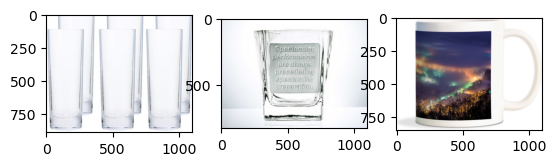

Watches


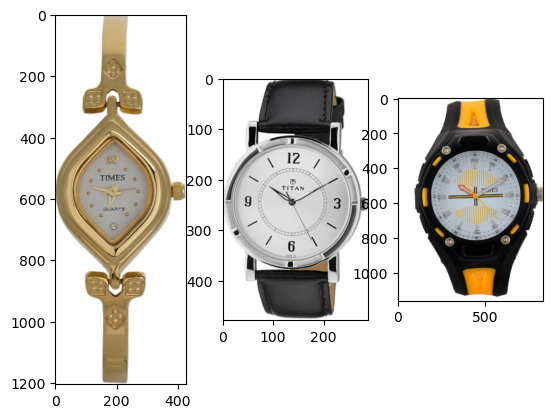

In [12]:
from matplotlib.image import imread

list_labels = data["label_name"].unique()

def list_fct(name) :
    list_image_name = [data["image_path"][i] for i in range(len(data)) if data["label_name"][i]==name]
    return list_image_name

for name in list_labels :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

# Étape 3 : Étudiez la faisabilité de classification en utilisant des techniques de traitement d'image avancées

## Classification automatique avec des réseaux de neurones pré-entraînés(VGG16)

### Création du modèle pré-entraîné

In [13]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


### Création des features des images

In [14]:
images_features_VGG16 = []
i=0 
for image_file in data["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features_VGG16.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features_VGG16 = np.asarray(images_features_VGG16)
images_features_VGG16.shape

0
100
200
300
400
500
600
700
800


(840, 4096)

In [15]:
# Sauvegarde de l'objet all_features dans un fichier binaire
with open(path_data + 'saved_features_VGG16.pkl', 'wb') as f:
    pickle.dump(images_features_VGG16, f)


In [16]:
# Chargement des caractéristiques extraites à partir du fichier
with open(path_data + 'saved_features_VGG16.pkl', 'rb') as f:
    loaded_features_VGG16 = pickle.load(f)

# Affichage pour confirmer le chargement
print("Shape of loaded features:", loaded_features_VGG16.shape)

Shape of loaded features: (840, 4096)


## Section 3 : Utilisez des méthodes de réduction de dimension sur les images encodées et comparer les résultats avec les catégories réelles. (VGG16)

Dans cette étape de notre projet, nous abordons l'étude de la faisabilité de classification automatique en utilisant des techniques de traitement d'image avancées. Nous adoptons une approche fondée sur l'emploi de réseaux de neurones convolutifs pré-entraînés, spécifiquement les modèles VGG16 et VGG19.

### Mise en place des PCA et t-SNE 

#### Réduction de dimension PCA

In [17]:
# Réduction de dimension PCA avec un nombre fixe de composants
pca = PCA(n_components=0.99)  # Essayer avec un nombre fixe de composants
feat_pca_VGG16 = pca.fit_transform(loaded_features_VGG16)
print("Shape of PCA-reduced features:", feat_pca_VGG16.shape)

if feat_pca_VGG16.shape[0] > 1:
    print("t-SNE done")
else:
    print("Not enough samples for t-SNE.")

Shape of PCA-reduced features: (840, 662)
t-SNE done


#### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [18]:
temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=7)
X_tsne_VGG16 = tsne.fit_transform(feat_pca_VGG16)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

  File "C:\Users\Farid\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


temps de T-SNE :             8.02 secondes


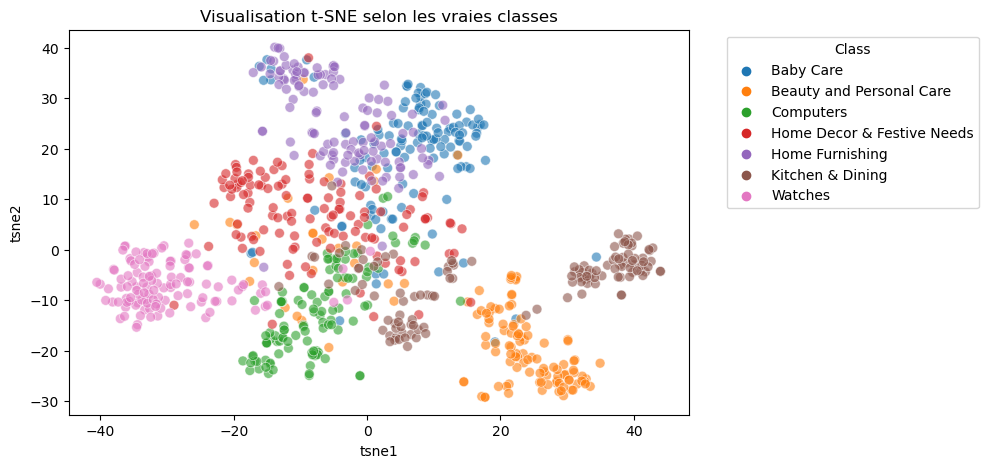

In [19]:
df_tsne = pd.DataFrame(X_tsne_VGG16, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('Visualisation t-SNE selon les vraies classes')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Création de clusters à partir du T-SNE et affichage des images selon clusters¶

Pour conforter notre analyse visuelle faite avec t-SNE, nous allons effectuer un clustering avec l'algorithme KMeans sur les données projetées par t-SNE, puis évaluer la qualité des clusters formés par rapport aux catégories réelles des données à l'aide de l'Index de Rand ajusté (ARI).

1. **Clustering avec KMeans :**
* Utiliser les résultats de t-SNE pour regrouper nos données.
* Choisir le nombre de clusters égal au nombre de catégories réelles observées.
2. **Calcul de l'ARI :**
* Comparer les clusters obtenus avec les étiquettes de classe réelles pour évaluer la cohérence des regroupements par rapport aux vraies catégories.
3. **Visualisation :**
* Visualiser les résultats du clustering pour voir si les regroupements correspondent visuellement aux classes réelles.

In [20]:
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne_VGG16)

KMeans(n_clusters=7, n_init=100)

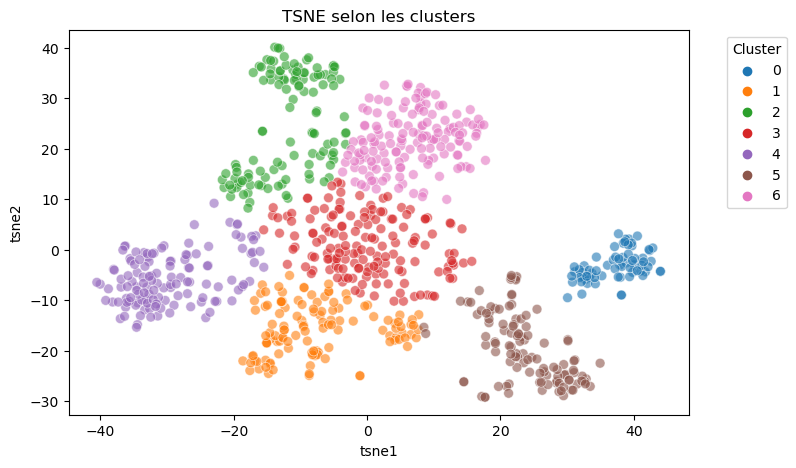

ARI : 0.45808472479249435


In [21]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

# Titre et étiquettes des axes avec un formatage personnalisé
plt.title('TSNE selon les clusters')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

labels = data["label"]
ari_VGG16 = metrics.adjusted_rand_score(labels, cls.labels_)
print("ARI :", ari_VGG16)

#### Analyse par classes

In [22]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[  1   1   8  18   2   2  91]
 [  0   4   3  11   6 102   3]
 [  0  81   0  30   0   1   0]
 [  0   4  40  60  10   1   5]
 [  0   0  64   2   1   0  48]
 [ 66  23   0  31   0   4   0]
 [  0   8   0   2 107   0   0]]


In [23]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [24]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [5 2 4 3 6 1 0]
[[ 91   2   1  18   8   1   2]
 [  3 102   4  11   3   0   6]
 [  0   1  81  30   0   0   0]
 [  5   1   4  60  40   0  10]
 [ 48   0   0   2  64   0   1]
 [  0   4  23  31   0  66   0]
 [  0   0   8   2   0   0 107]]

              precision    recall  f1-score   support

           0       0.62      0.74      0.67       123
           1       0.93      0.79      0.85       129
           2       0.67      0.72      0.70       112
           3       0.39      0.50      0.44       120
           4       0.56      0.56      0.56       115
           5       0.99      0.53      0.69       124
           6       0.85      0.91      0.88       117

    accuracy                           0.68       840
   macro avg       0.71      0.68      0.68       840
weighted avg       0.72      0.68      0.69       840



In [25]:
list_labels = labels.unique().tolist()
print(list_labels)

[0, 1, 2, 3, 4, 5, 6]


<AxesSubplot:>

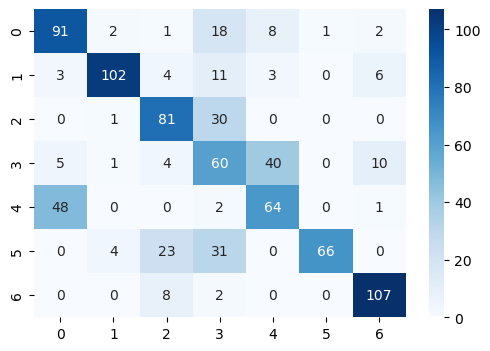

In [28]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in list_labels])

fmt='d'
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt=fmt)

## Section 2 : Classification automatique avec des réseaux de neurones pré-entraînés(VGG19)

### Initialisation de VGG19

In [29]:
#base_model = VGG16(weights='imagenet', include_top=False)
base_model = VGG19()
model2 = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model2.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 139,570,240 (532.42 MB)

 Trainable params: 139,570,240 (532.42 MB)

 Non-trainable params: 0 (0.00 B)

None


### Liste pour stocker les caractéristiques extraites des images

In [30]:
images_features_VGG19 = []
i=0 
for image_file in data["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features_VGG19.append(model2.predict(image, verbose=0)[0]) # predict from pretrained model

images_features_VGG19 = np.asarray(images_features_VGG19)
images_features_VGG19.shape

# Sauvegarde de l'objet all_features dans un fichier binaire
with open(path_data + 'saved_features_VGG19.pkl', 'wb') as f:
    pickle.dump(images_features_VGG19, f)

0
100
200
300
400
500
600
700
800


In [31]:
# Chargement des caractéristiques extraites à partir du fichier
with open(path_data + 'saved_features_VGG19.pkl', 'rb') as f:
    loaded_features_VGG19 = pickle.load(f)

# Affichage pour confirmer le chargement
print("Shape of loaded features:", loaded_features_VGG19.shape)

Shape of loaded features: (840, 4096)


## Section 3 : Utilisez des méthodes de réduction de dimension sur les images encodées et comparer les résultats avec les catégories réelles. (VGG19)

### Mise en place des PCA et t-SNE

#### Réduction de dimension PCA

In [32]:
pca = PCA(n_components=0.99)
feat_pca_VGG19 = pca.fit_transform(loaded_features_VGG19)
print("Shape of PCA-reduced features:", feat_pca_VGG19.shape)

if feat_pca_VGG19.shape[0] > 1:
    print("t-SNE done")
else:
    print("Not enough samples for t-SNE.")

Shape of PCA-reduced features: (840, 657)
t-SNE done


#### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [33]:
temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=8)
X_tsne_VGG19 = tsne.fit_transform(feat_pca_VGG19)

duration1=time.time()-temps1
print(f"Temps de T-SNE : {duration1:15.2f} secondes")

Temps de T-SNE :            7.36 secondes


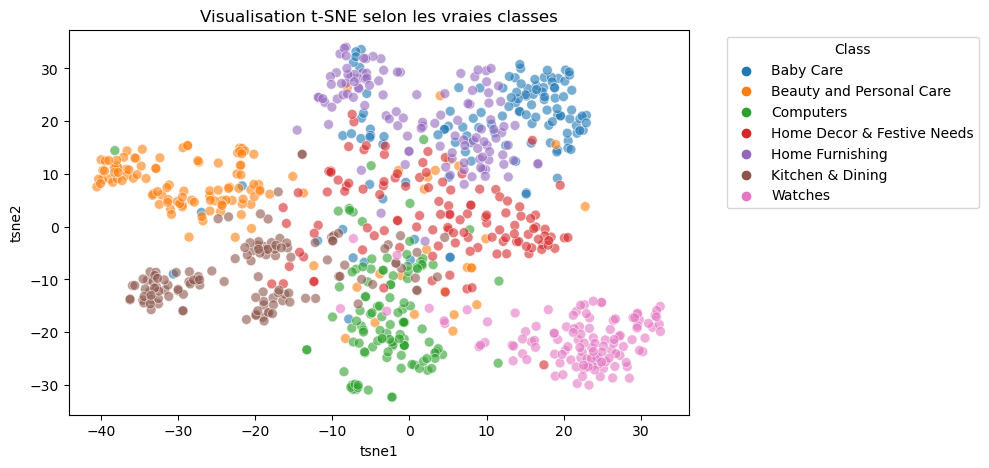

In [34]:
df_tsne = pd.DataFrame(X_tsne_VGG19, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('Visualisation t-SNE selon les vraies classes')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Création de clusters à partir du T-SNE et affichage des images selon clusters¶

In [35]:
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne_VGG19)

KMeans(n_clusters=7, n_init=100)

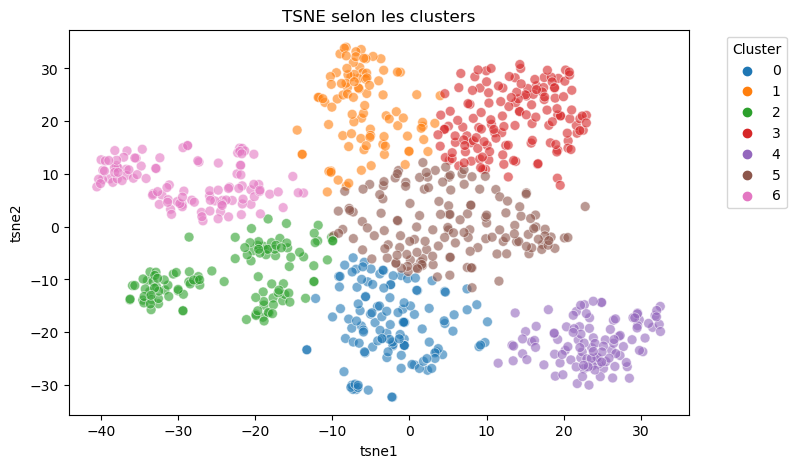

ARI : 0.5233273312403294


In [36]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Calcul et affichage de l'ARI
ari_VGG19 = metrics.adjusted_rand_score(labels, cls.labels_)
print("ARI :", ari_VGG19)

#### Analyse par classes

In [37]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[  3  16   2  89   0  11   2]
 [ 10   2   4   3   0  10 100]
 [ 87   2   0   0   1  21   1]
 [  4  15  10   3   1  85   2]
 [  0  58   0  49   0   8   0]
 [ 10   2  97   0   0  11   4]
 [ 10   0   0   0 105   2   0]]


In [38]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [2 4 5 0 6 3 1]
[[ 89   2   3  11  16   2   0]
 [  3 100  10  10   2   4   0]
 [  0   1  87  21   2   0   1]
 [  3   2   4  85  15  10   1]
 [ 49   0   0   8  58   0   0]
 [  0   4  10  11   2  97   0]
 [  0   0  10   2   0   0 105]]

              precision    recall  f1-score   support

           0       0.62      0.72      0.67       123
           1       0.92      0.78      0.84       129
           2       0.70      0.78      0.74       112
           3       0.57      0.71      0.63       120
           4       0.61      0.50      0.55       115
           5       0.86      0.78      0.82       124
           6       0.98      0.90      0.94       117

    accuracy                           0.74       840
   macro avg       0.75      0.74      0.74       840
weighted avg       0.75      0.74      0.74       840



<AxesSubplot:>

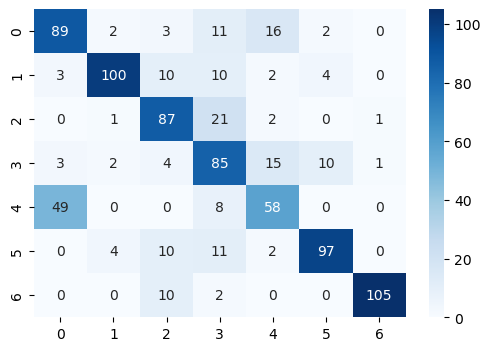

In [40]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in list_labels])

fmt='d'
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt=fmt)